This notebook organizes all the results in the "analysis" folder within a concrete storyline

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is converted to HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils_read_parsing
from utils_timeline_viz import *
from utils_read_parsing import *
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import ranksums
import seaborn as sns
import statsmodels.api as sm
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
from statsmodels.discrete.discrete_model import Logit
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 7, 4
pd.set_option('precision',3)
np.set_printoptions(precision=3,suppress=True)

d:\applications\anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Preparing the data
We wish to have a table that looks like:

In [3]:
t = [['student','variable','pre','post','index','sim','CVS table','CVS graph']]
t.append(['s1','v1','1.0','2.333','1','L','Yes','No'])
t.append(['s1','v2','...','...','1','L','Yes','Yes'])
t.append(['s1','v3','...','...','2','C','No','No'])
t.append(['s1','v4','...','...','2','C','Yes','No'])
print tabulate(t)

-------  --------  ---  -----  -----  ---  ---------  ---------
student  variable  pre  post   index  sim  CVS table  CVS graph
s1       v1        1.0  2.333  1      L    Yes        No
s1       v2        ...  ...    1      L    Yes        Yes
s1       v3        ...  ...    2      C    No         No
s1       v4        ...  ...    2      C    Yes        No
-------  --------  ---  -----  -----  ---  ---------  ---------


## Grabing the CVS data...

In [4]:
table_cvs_df = pd.read_csv('table_cvs_results.txt', sep='\t')
graph_cvs_df = pd.read_csv('graph_cvs_results.txt', sep='\t')

In [5]:
metadf = get_student_metadata()
order = dict(zip(metadf.index,metadf['activity order']))
graph_cvs_df['activity order'] = graph_cvs_df.studentid.apply(lambda sid: order[sid])
table_cvs_df['activity order'] = table_cvs_df.studentid.apply(lambda sid: order[sid])

In [6]:
variables = ["Area","Separation","Width","Concentration","Wavelength","Battery voltage"]

def binarize(threshold,number):
    if number>= threshold : return 1
    else: return 0
    
# Given that we want to compare the stringency of CVS, we created different definitions with 2,3,4 points needed

graph_cvs_2_df = graph_cvs_df.copy()
graph_cvs_3_df = graph_cvs_df.copy()
graph_cvs_4_df = graph_cvs_df.copy()
graph_cvs_5_df = graph_cvs_df.copy()
for v in variables:
    graph_cvs_2_df[v] = graph_cvs_df.apply(lambda row: binarize(2,row[v]), axis=1)
    graph_cvs_3_df[v] = graph_cvs_df.apply(lambda row: binarize(3,row[v]), axis=1)
    graph_cvs_4_df[v] = graph_cvs_df.apply(lambda row: binarize(4,row[v]), axis=1)
    graph_cvs_5_df[v] = graph_cvs_df.apply(lambda row: binarize(5,row[v]), axis=1)

table_cvs_2_df = table_cvs_df.copy()
table_cvs_3_df = table_cvs_df.copy()
table_cvs_4_df = table_cvs_df.copy()
table_cvs_5_df = table_cvs_df.copy()
for v in variables:
    table_cvs_2_df[v] = table_cvs_df.apply(lambda row: binarize(2,row[v]), axis=1)
    table_cvs_3_df[v] = table_cvs_df.apply(lambda row: binarize(3,row[v]), axis=1)
    table_cvs_4_df[v] = table_cvs_df.apply(lambda row: binarize(4,row[v]), axis=1)
    table_cvs_5_df[v] = table_cvs_df.apply(lambda row: binarize(5,row[v]), axis=1)

In [7]:
# table_intervals_df = pd.read_csv('table_intervals_results.txt', sep='\t')

## Grabbing the worksheet data

In [8]:
%reload_ext utils_read_parsing
#grab worksheet data
worksheets = get_worksheet_metadata('beers')
pre = get_pre_worksheet(sim='beers')
main = get_main_worksheet(sim='beers')

ids = get_students_to_analyze_log_worksheets('beers')
pre= pre[pre['Student ID'].isin(worksheets[(worksheets['Type']=='p')&worksheets['Student ID'].isin(ids)]['other id'].values)]
main= main[main['Student ID'].isin(worksheets[(worksheets['Type']=='m')&worksheets['Student ID'].isin(ids)]['other id'].values)]

#ids in pre/post match "other id" in worksheet metdata so we need to assign the correct id in logs for each entry in pre/post
pre['sid'] = pre['Student ID'].apply(lambda row: worksheets.loc[worksheets[(worksheets['other id']==row)].index[0],'Student ID'])
main['sid'] = main['Student ID'].apply(lambda row: worksheets.loc[worksheets[worksheets['other id']==row].index[0],'Student ID'])

# print len(ids),len(pre),len(main)

In [9]:
## make desired table for beers
melted_pre = pd.melt(pre, id_vars=['sid'], value_vars=['Concentration','Width'], var_name='variable',value_name='pre')
melted_main = pd.melt(main, id_vars=['sid'], value_vars=['Concentration','Width'], var_name='variable',value_name='main')

L_scores = melted_pre.merge(melted_main, on=['sid','variable'], how='outer')
L_scores['sim'] = 'L'

L_scores['CVS_table_2'] = L_scores.apply(lambda row: table_cvs_2_df.loc[table_cvs_2_df[table_cvs_2_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
L_scores['CVS_graph_2'] = L_scores.apply(lambda row: graph_cvs_2_df.loc[graph_cvs_2_df[graph_cvs_2_df['studentid']==row['sid']].index[0],row['variable']],axis=1)

L_scores['CVS_table_3'] = L_scores.apply(lambda row: table_cvs_3_df.loc[table_cvs_3_df[table_cvs_3_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
L_scores['CVS_graph_3'] = L_scores.apply(lambda row: graph_cvs_3_df.loc[graph_cvs_3_df[graph_cvs_3_df['studentid']==row['sid']].index[0],row['variable']],axis=1)

L_scores['CVS_table_4'] = L_scores.apply(lambda row: table_cvs_4_df.loc[table_cvs_4_df[table_cvs_4_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
L_scores['CVS_graph_4'] = L_scores.apply(lambda row: graph_cvs_4_df.loc[graph_cvs_4_df[graph_cvs_4_df['studentid']==row['sid']].index[0],row['variable']],axis=1)

L_scores['CVS_table_5'] = L_scores.apply(lambda row: table_cvs_5_df.loc[table_cvs_5_df[table_cvs_5_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
L_scores['CVS_graph_5'] = L_scores.apply(lambda row: graph_cvs_5_df.loc[graph_cvs_5_df[graph_cvs_5_df['studentid']==row['sid']].index[0],row['variable']],axis=1)


L_scores['number_points_table'] = L_scores.apply(lambda row: table_cvs_df.loc[table_cvs_df[table_cvs_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
L_scores['number_points_graph'] = L_scores.apply(lambda row: graph_cvs_df.loc[graph_cvs_df[graph_cvs_df['studentid']==row['sid']].index[0],row['variable']],axis=1)

L_scores['sim_index'] = L_scores.apply(lambda row: table_cvs_2_df.loc[table_cvs_2_df[table_cvs_2_df['studentid']==row['sid']].index[0],'activity order'].index(row['sim'])+1,axis=1)

In [10]:
# L_scores[L_scores['variable']=='Width'].describe()

In [11]:
%reload_ext utils_read_parsing
#grab worksheet data
worksheets = get_worksheet_metadata('caps')
pre = get_pre_worksheet(sim='caps')
main = get_main_worksheet(sim='caps')

ids = get_students_to_analyze_log_worksheets('caps')
pre= pre[pre['Student ID'].isin(worksheets[(worksheets['Type']=='p')&worksheets['Student ID'].isin(ids)]['other id'].values)]
main= main[main['Student ID'].isin(worksheets[(worksheets['Type']=='m')&worksheets['Student ID'].isin(ids)]['other id'].values)]

#ids in pre/post match "other id" in worksheet metdata so we need to assign the correct id in logs for each entry in pre/post
pre['sid'] = pre['Student ID'].apply(lambda row: worksheets.loc[worksheets[(worksheets['other id']==row)].index[0],'Student ID'])
main['sid'] = main['Student ID'].apply(lambda row: worksheets.loc[worksheets[worksheets['other id']==row].index[0],'Student ID'])

# print len(ids),len(pre),len(main)

In [12]:
## make desired table for caps
melted_pre = pd.melt(pre, id_vars=['sid'], value_vars=['Area','Separation'], var_name='variable',value_name='pre')
melted_main = pd.melt(main, id_vars=['sid'], value_vars=['Area','Separation'], var_name='variable',value_name='main')

C_scores = melted_pre.merge(melted_main, on=['sid','variable'], how='outer')
C_scores['sim'] = 'C'
C_scores['CVS_table_2'] = C_scores.apply(lambda row: table_cvs_2_df.loc[table_cvs_2_df[table_cvs_2_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
C_scores['CVS_graph_2'] = C_scores.apply(lambda row: graph_cvs_2_df.loc[graph_cvs_2_df[graph_cvs_2_df['studentid']==row['sid']].index[0],row['variable']],axis=1)

C_scores['CVS_table_3'] = C_scores.apply(lambda row: table_cvs_3_df.loc[table_cvs_3_df[table_cvs_3_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
C_scores['CVS_graph_3'] = C_scores.apply(lambda row: graph_cvs_3_df.loc[graph_cvs_3_df[graph_cvs_3_df['studentid']==row['sid']].index[0],row['variable']],axis=1)

C_scores['CVS_table_4'] = C_scores.apply(lambda row: table_cvs_4_df.loc[table_cvs_4_df[table_cvs_4_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
C_scores['CVS_graph_4'] = C_scores.apply(lambda row: graph_cvs_4_df.loc[graph_cvs_4_df[graph_cvs_4_df['studentid']==row['sid']].index[0],row['variable']],axis=1)

C_scores['CVS_table_5'] = C_scores.apply(lambda row: table_cvs_5_df.loc[table_cvs_5_df[table_cvs_5_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
C_scores['CVS_graph_5'] = C_scores.apply(lambda row: graph_cvs_5_df.loc[graph_cvs_5_df[graph_cvs_5_df['studentid']==row['sid']].index[0],row['variable']],axis=1)

C_scores['number_points_table'] = C_scores.apply(lambda row: table_cvs_df.loc[table_cvs_df[table_cvs_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
C_scores['number_points_graph'] = C_scores.apply(lambda row: graph_cvs_df.loc[graph_cvs_df[graph_cvs_df['studentid']==row['sid']].index[0],row['variable']],axis=1)

C_scores['sim_index'] = C_scores.apply(lambda row: table_cvs_2_df.loc[table_cvs_2_df[table_cvs_2_df['studentid']==row['sid']].index[0],'activity order'].index(row['sim'])+1,axis=1)

## Putting it all together

In [13]:
data = pd.concat([L_scores,C_scores])
# data['intervals_in_table'] = data.apply(lambda row: table_intervals_df.loc[table_intervals_df[table_intervals_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
# data['CVS_table_only'] = data.apply(lambda row: row['CVS_table']*(1-row['CVS_graph']), axis = 1)
data = data.reset_index(drop=True)

## Adding wrapper use data

In [14]:
use_wrapper_df = pd.read_csv('use_wrapper_results.txt', sep='\t')
data['use_table'] = data.apply(lambda row: use_wrapper_df.loc[use_wrapper_df[use_wrapper_df['studentid']==row['sid']].index[0],'use_table'], axis=1)
data['use_graph'] = data.apply(lambda row: use_wrapper_df.loc[use_wrapper_df[use_wrapper_df['studentid']==row['sid']].index[0],'use_graph'], axis=1)
data[['use_table','use_graph']].describe()

,use_table,use_graph
count,592.0,592.000
mean,1.0,0.845
std,0.0,0.363
min,1.0,0.000
25%,1.0,1.000
50%,1.0,1.000
75%,1.0,1.000
max,1.0,1.000


Everyone uses the table once and 85% use the graph once. Lets redo the analysis only with students who used the graph

## Adding pre-survey data

In [15]:
pre_survey_df = pd.read_csv('pre_survey_results.txt', sep='\t')
pre_survey_df.head()

,Unnamed: 0,sid,level_experience_sims,similar_L,similar_C,experience_undergrad_labs
0,5,77047160,2,0,0,1
1,6,23836160,0,0,0,1
2,7,64006159,1,0,0,1
3,8,24566161,3,0,1,1
4,9,46792161,2,1,0,1


In [16]:
data['level_experience_sims'] = data.apply(lambda row: pre_survey_df.loc[pre_survey_df[pre_survey_df['sid']==row['sid']].index[0],'level_experience_sims'], axis=1)
data['experience_undergrad_labs'] = data.apply(lambda row: pre_survey_df.loc[pre_survey_df[pre_survey_df['sid']==row['sid']].index[0],'experience_undergrad_labs'], axis=1)
data['used_similar_sim_L'] = data[data['sim']=='L'].apply(lambda row: pre_survey_df.loc[pre_survey_df[pre_survey_df['sid']==row['sid']].index[0],'similar_L'],axis=1)
data['used_similar_sim_L'].fillna(0, inplace=True)
data['used_similar_sim_C'] = data[data['sim']=='C'].apply(lambda row: pre_survey_df.loc[pre_survey_df[pre_survey_df['sid']==row['sid']].index[0],'similar_C'],axis=1)
data['used_similar_sim_C'].fillna(0, inplace=True)
data['used_similar_sim'] = data['used_similar_sim_L'] + data['used_similar_sim_C']

We add a "CVS_levels" column to our data (graph=2, table=1, none=0)

In [17]:
data['CVS_levels_2']=0
data['CVS_levels_3']=0
data['CVS_levels_4']=0
data['CVS_levels_5']=0
# data['CVS_table_only'] = data.apply(lambda row: row['CVS_table']*(1-row['CVS_graph']), axis = 1)
data['CVS_levels_2']=data['CVS_table_2']+data['CVS_graph_2']
data['CVS_levels_3']=data['CVS_table_3']+data['CVS_graph_3']
data['CVS_levels_4']=data['CVS_table_4']+data['CVS_graph_4']
data['CVS_levels_5']=data['CVS_table_5']+data['CVS_graph_5']
print data[(data['CVS_table_2']==0)&(data['CVS_graph_2']==1)].shape
print data[(data['CVS_table_3']==0)&(data['CVS_graph_3']==1)].shape
print data[(data['CVS_table_4']==0)&(data['CVS_graph_4']==1)].shape
print data[(data['CVS_table_5']==0)&(data['CVS_graph_5']==1)].shape

(0, 27)
(0, 27)
(1, 27)
(0, 27)


In [18]:
data.sort_values('sid').head(12)

,sid,variable,pre,main,sim,CVS_table_2,CVS_graph_2,CVS_table_3,CVS_graph_3,CVS_table_4,...,use_graph,level_experience_sims,experience_undergrad_labs,used_similar_sim_L,used_similar_sim_C,used_similar_sim,CVS_levels_2,CVS_levels_3,CVS_levels_4,CVS_levels_5
0,10127163,Concentration,1.0,3.0,L,1,1,1,1,1,...,1,1,1,0.0,0.0,0.0,2,2,2,2
148,10127163,Width,1.0,3.0,L,1,1,1,1,1,...,1,1,1,0.0,0.0,0.0,2,2,2,2
296,10127163,Area,3.0,3.0,C,1,1,1,1,1,...,1,1,1,0.0,0.0,0.0,2,2,2,2
444,10127163,Separation,3.0,3.0,C,1,1,1,1,1,...,1,1,1,0.0,0.0,0.0,2,2,2,2
538,10192168,Separation,1.0,2.0,C,1,1,1,1,1,...,1,1,1,0.0,0.0,0.0,2,2,2,0
96,10192168,Concentration,1.0,3.0,L,1,1,1,1,1,...,1,1,1,0.0,0.0,0.0,2,2,2,2
390,10192168,Area,1.0,2.0,C,1,0,0,0,0,...,1,1,1,0.0,0.0,0.0,1,0,0,0
244,10192168,Width,1.0,0.0,L,1,0,1,0,1,...,1,1,1,0.0,0.0,0.0,1,1,1,1
1,10232160,Concentration,1.0,1.0,L,1,1,1,1,1,...,1,1,1,1.0,0.0,1.0,2,2,2,0
149,10232160,Width,1.0,1.0,L,0,0,0,0,0,...,1,1,1,1.0,0.0,1.0,0,0,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000006808390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000106FCD68>]], dtype=object)

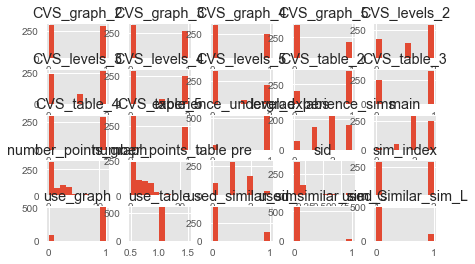

In [19]:
data.hist()

## Exporting the data

In [20]:
# export_data = data[["sid","variable","pre","main","sim","CVS_graph","sim_index"]]
export_data = data.copy()
export_data.to_csv('dataframe_all_factors_by_student_x_variable.csv')

## Stats tools and multicollinearity check

In [21]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

def clean_summary(model):
    lines = model.summary().as_text().split('\n')
    lines = [l for l in lines if 'C(sid)' not in l]
    return '\n'.join(lines)

In [22]:
# from scipy import stats
# print "Correlation coeff for table and graph CVS:", stats.spearmanr(data['CVS_table'],data['CVS_graph'])
# #Let's measure the variance inflation factor of including both CVS table and graph in the same models:
# formula = 'CVS_table ~ CVS_graph + pre + C(variable) + sim_index + C(sim) '
# print 'model: ', formula,'\n'
# from patsy import dmatrices
# Y, X = dmatrices(formula, data, return_type = 'dataframe')
# # print X.columns
# logit = Logit(Y, X)
# model = logit.fit()
# print model.summary()
# # print model.params
# R2 = 0.4225
# VIF = 1.0/(1-R2)
# VIF

## A VIF of 1.73 tells us that the variance (the square of the standard error) of a particular coefficient is 73% larger than it would be if that predictor was completely uncorrelated with all the other predictors. According to [this website](https://statisticalhorizons.com/multicollinearity), a VIF of 2.6 or higher is worrisome.

# Results to present in methods
## Student population

In [23]:
N = len(set(data['sid']))
print "The study includes {0} students".format(N)

The study includes 148 students


In [24]:
posts = get_all_posts_surveys()
genders = ['gender','[gender] To which gender do you most identify? [Man]','[gender] To which gender do you most identify? [Gender non conforming/non-binary]','[gender] To which gender do you most identify? [Trans*]','[gender] To which gender do you most identify? [Rather specify:]','[gender] To which gender do you most identify? [Rather specify:] [text]','[gender] To which gender do you most identify? [Prefer not to answer]']
for g in genders:
    if '?' in g:
        gender = g.split('?')[1]
    else:
        gender = ' [Woman]'
    print gender, len(set(posts[posts[g]==1]['sid'])), round(len(set(posts[posts[g]==1]['sid']))/float(N)*100,1)

 [Woman] 96 64.9
 [Man] 50 33.8
 [Gender non conforming/non-binary] 1 0.7
 [Trans*] 0 0.0
 [Rather specify:] 0 0.0
 [Rather specify:] [text] 0 0.0
 [Prefer not to answer] 1 0.7


## Student prior experience

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000010A8ABE0>]], dtype=object)

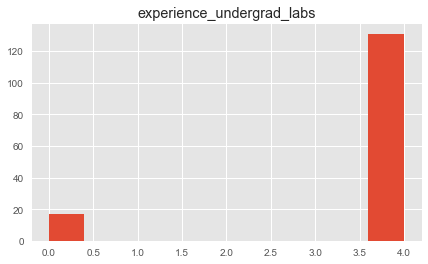

In [25]:
# print 'experience in virtual labs in general'
pd.pivot_table(data, values=['experience_undergrad_labs'], index=['sid'],aggfunc=np.sum)[['experience_undergrad_labs']].hist()

where:
 0 -> None
 1 -> 1-2 (roughly)
 2 -> 3-5 (roughly)
 3 -> 6+ (roughly)


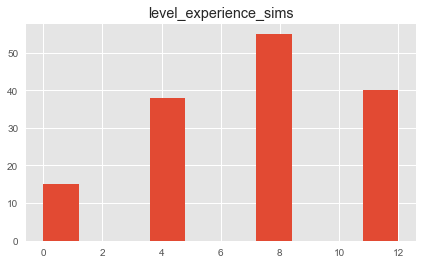

In [26]:
pd.pivot_table(data, values=['level_experience_sims'], index=['sid'],aggfunc=sum)[['level_experience_sims']].hist()
print '''where:
 0 -> None
 1 -> 1-2 (roughly)
 2 -> 3-5 (roughly)
 3 -> 6+ (roughly)'''

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000011BBBB70>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000011BADDD8>]], dtype=object)

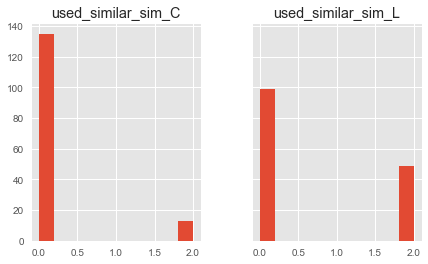

In [27]:
# print  'experience in virtual labs teaching light absorbance or capacitors before'
pd.pivot_table(data, values=['used_similar_sim_C','used_similar_sim_L'], index=['sid'],aggfunc=np.sum)[['used_similar_sim_C','used_similar_sim_L']].hist(sharey=True)

# Learning through inquiry
## Overall

Let's look at pre to post to see if students learn.

Right now we have 4 entries per student and add "variable" to the model.

In [28]:
scores = pd.pivot_table(data, values=['pre','main'], index=['variable','sid'],aggfunc=np.mean)
scores.reset_index(level=0, inplace=True)
scores['sid']=scores.index
scores.index = scores['variable']
scores.head()

,variable,main,pre,sid
variable,,,,
Area,Area,3.0,3.0,10127163
Area,Area,2.0,1.0,10192168
Area,Area,3.0,1.0,10232160
Area,Area,3.0,1.0,10375163
Area,Area,3.0,2.0,10420167


In [29]:
t = [['variable','pre','post','Z','p','effect size']]
for variable in ['Width','Concentration','Area','Separation']:
    pm = round(np.mean(scores.loc[variable]['pre']),2)
    ps = round(np.std(scores.loc[variable]['pre']),2)
    mm = round(np.mean(scores.loc[variable]['main']),2)
    ms = round(np.std(scores.loc[variable]['main']),2)
    Z,p = ranksums(scores.loc[variable]['pre'],scores.loc[variable]['main'])
    eta = round(-Z/np.sqrt(N),2)
    t.append([variable,str(pm)+'+/-'+str(ps),str(mm)+'+/-'+str(ms),Z,p,eta])

print tabulate(t)

-------------  -----------  -----------  --------------  -----------------  -----------
variable       pre          post         Z               p                  effect size
Width          1.03+/-0.83  2.32+/-0.75  -10.606544349   2.77835422465e-26  0.87
Concentration  1.31+/-0.79  2.39+/-0.64  -9.90777143556  3.85140941905e-23  0.81
Area           1.24+/-0.82  2.28+/-0.71  -9.50983078709  1.90972924202e-21  0.78
Separation     1.32+/-0.79  2.19+/-0.68  -8.35403729954  6.59685008135e-17  0.69
-------------  -----------  -----------  --------------  -----------------  -----------


We use Wilcoxon signed rank test since our population ares paired and dependant but ordinal values. Overall, student learn in both sims.

For calculation and interpretation of effect size, read Pages 224 (bottom part) and 225 from Pallant, J. (2007). SPSS Survival Manual quoted [here](https://stats.stackexchange.com/questions/133077/effect-size-to-wilcoxon-signed-rank-test)


In [30]:
from scipy.stats import spearmanr
print "\nCorrelation for all variables: (N=148*4)"
print spearmanr(data['pre'],data['main'])
print "\nCorrelation using mean pre and mean main merging both sims: (N=148)"
merged_scores = pd.pivot_table(data, values=['pre','main'], index=['sid'],aggfunc=np.mean)
print spearmanr(merged_scores['pre'],merged_scores['main'])


Correlation for all variables: (N=148*4)
SpearmanrResult(correlation=0.19683704156643292, pvalue=1.390052759857402e-06)

Correlation using mean pre and mean main merging both sims: (N=148)
SpearmanrResult(correlation=0.3606523617550455, pvalue=6.7061187707435308e-06)


# Does using strategy help student learn?

## Using different levels of CVS and learning

In [31]:
data.head()

,sid,variable,pre,main,sim,CVS_table_2,CVS_graph_2,CVS_table_3,CVS_graph_3,CVS_table_4,...,use_graph,level_experience_sims,experience_undergrad_labs,used_similar_sim_L,used_similar_sim_C,used_similar_sim,CVS_levels_2,CVS_levels_3,CVS_levels_4,CVS_levels_5
0,10127163,Concentration,1.0,3.0,L,1,1,1,1,1,...,1,1,1,0.0,0.0,0.0,2,2,2,2
1,10232160,Concentration,1.0,1.0,L,1,1,1,1,1,...,1,1,1,1.0,0.0,1.0,2,2,2,0
2,10537160,Concentration,1.0,2.0,L,1,0,1,0,0,...,0,1,1,1.0,0.0,1.0,1,1,0,0
3,10375163,Concentration,0.0,2.0,L,1,0,1,0,1,...,1,2,1,0.0,0.0,0.0,1,1,1,1
4,10420167,Concentration,1.0,3.0,L,1,1,1,1,1,...,1,3,1,0.0,0.0,0.0,2,2,2,2


We have 8 control variables:
* sim_index
* sim
* variable
* pre
* level_experience_sims
* experience_undergrad_labs
* used_similar_sim
* use_graph

We look at all interactions with CVS levels given our RQ are related to CVS usage:
* variable*CVS_levels
* pre*CVS_levels
* sim_index*CVS_levels
* sim (exclude becasue already within variable?)
* C(sid)
* level_experience_sims
* experience_undergrad_labs
* used_similar_sim
* use_graph


*NOTE:* we don't include variable and sim in the same model

We first remove students with max pre for a certain variable

In [32]:
print data.shape
filtered_maxpre_data = data.copy()
filtered_maxpre_data = filtered_maxpre_data[filtered_maxpre_data['pre']<3]
print filtered_maxpre_data.shape

(592, 27)
(553, 27)


In [33]:
# covariates_for_interaction_model = " + sim_index + C(sid) + level_experience_sims + experience_undergrad_labs + used_similar_sim"
covariates_for_parsimonious_model = "+ variable + pre + sim_index + C(sid) + level_experience_sims + experience_undergrad_labs + used_similar_sim"

In [34]:
formula = 'main ~ C(CVS_levels_3) '+ covariates_for_parsimonious_model
model = ols(formula, filtered_maxpre_data).fit()
print "\n\nModel: ",formula
aov_table = anova_lm(model, typ=3)
eta_squared(aov_table)
omega_squared(aov_table)
print "\nAnova table using type 3\n"
print(aov_table)
print "\nHere is the linear model with coefficients and confidence intervals (removed stats for individual student ids):\n"
print clean_summary(model)



Model:  main ~ C(CVS_levels_3) + variable + pre + sim_index + C(sid) + level_experience_sims + experience_undergrad_labs + used_similar_sim

Anova table using type 3

                            sum_sq     df        F     PR(>F)     eta_sq   omega_sq
Intercept                   29.578    1.0  108.949  1.063e-22  9.121e-02  9.030e-02
C(CVS_levels_3)              5.283    2.0    9.730  7.489e-05  1.629e-02  1.461e-02
variable                     2.433    3.0    2.988  3.101e-02  7.504e-03  4.988e-03
C(sid)                     174.445  147.0    4.371  1.173e-31  5.380e-01  4.145e-01
pre                          0.007    1.0    0.026  8.730e-01  2.140e-05 -8.151e-04
sim_index                    3.566    1.0   13.136  3.273e-04  1.100e-02  1.015e-02
level_experience_sims        0.406    1.0    1.494  2.223e-01  1.251e-03  4.132e-04
experience_undergrad_labs    0.722    1.0    2.660  1.037e-01  2.227e-03  1.389e-03
used_similar_sim             0.050    1.0    0.184  6.681e-01  1.541e-04 -6

## Sensitivity analysis on CVS criteria using BIC

In [35]:
for CVS in ['CVS_levels_2','CVS_levels_3','CVS_levels_4','CVS_levels_5']:
    formula = 'main ~ C('+CVS+')' + covariates_for_parsimonious_model
    model = ols(formula, filtered_maxpre_data).fit()
    print "\n\nModel: ",formula
    aov_table = anova_lm(model, typ=3)
    eta_squared(aov_table)
    omega_squared(aov_table)
    print "\nAnova table using type 3\n"
    print(aov_table)
    print "\nHere is the linear model with coefficients and confidence intervals (removed stats for individual student ids):\n"
    print clean_summary(model)



Model:  main ~ C(CVS_levels_2)+ variable + pre + sim_index + C(sid) + level_experience_sims + experience_undergrad_labs + used_similar_sim

Anova table using type 3

                            sum_sq     df       F     PR(>F)     eta_sq   omega_sq
Intercept                   26.839    1.0  99.205  5.234e-21  8.416e-02  8.324e-02
C(CVS_levels_2)              5.656    2.0  10.453  3.766e-05  1.773e-02  1.602e-02
variable                     2.713    3.0   3.342  1.931e-02  8.506e-03  5.956e-03
C(sid)                     171.035  147.0   4.301  5.489e-31  5.363e-01  4.113e-01
pre                          0.028    1.0   0.103  7.484e-01  8.742e-05 -7.603e-04
sim_index                    3.940    1.0  14.563  1.572e-04  1.235e-02  1.150e-02
level_experience_sims        0.442    1.0   1.632  2.021e-01  1.385e-03  5.361e-04
experience_undergrad_labs    0.803    1.0   2.967  8.575e-02  2.517e-03  1.667e-03
used_similar_sim             0.051    1.0   0.189  6.641e-01  1.603e-04 -6.875e-04
Re


Anova table using type 3

                            sum_sq     df        F     PR(>F)     eta_sq   omega_sq
Intercept                   30.066    1.0  109.940  7.183e-23  9.210e-02  9.118e-02
C(CVS_levels_4)              4.494    2.0    8.216  3.189e-04  1.377e-02  1.208e-02
variable                     2.437    3.0    2.970  3.174e-02  7.464e-03  4.947e-03
C(sid)                     176.102  147.0    4.381  9.551e-32  5.394e-01  4.159e-01
pre                          0.011    1.0    0.039  8.433e-01  3.280e-05 -8.042e-04
sim_index                    3.620    1.0   13.239  3.104e-04  1.109e-02  1.024e-02
level_experience_sims        0.406    1.0    1.486  2.236e-01  1.245e-03  4.065e-04
experience_undergrad_labs    0.720    1.0    2.634  1.054e-01  2.207e-03  1.368e-03
used_similar_sim             0.035    1.0    0.127  7.218e-01  1.064e-04 -7.307e-04
Residual                   108.568  397.0      NaN        NaN        NaN        NaN

Here is the linear model with coefficients and c

These results were produced using AOV of linear regression with Type III SS

We think a threshold of 3 pts is stricks a balance between 1) measuring more deliberatness than 2 pts and 2) it is less stringent than using more points.

Here are the AIC and BIC of the models (lower means better model controlling for number of parameters)


    no interactions
    #pts	R^2
    2		0.449
    3		0.447
    4		0.443
    5		0.428

None of these models are drastically different from each other, thought 5pts is definitely the worst

We pick #pts = 3 and call it a day

### Models per variable

This plot needs to be redone with standard deviation bars and organized by sim, colored by level


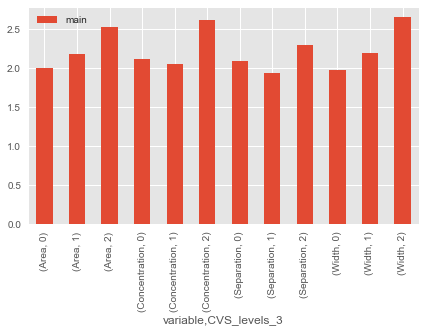

In [36]:
per_variable = pd.pivot_table(filtered_maxpre_data, values=['main'], index=['variable','CVS_levels_3'],aggfunc=(np.mean))
per_variable.plot(kind='bar')
print "This plot needs to be redone with standard deviation bars and organized by sim, colored by level"

In [37]:
covariates_for_variable_models = " + pre + sim_index + level_experience_sims + experience_undergrad_labs + used_similar_sim + use_graph"

In [38]:
for variable in ['Width', 'Concentration','Area','Separation']:
    print "__________________________________\nFOR VARIABLE ", variable, '\n__________________________________'
    formula = 'main ~ C(CVS_levels_3)' + covariates_for_variable_models
    model = ols(formula, filtered_maxpre_data[filtered_maxpre_data['variable']==variable]).fit()
    print "\n\nModel: ",formula
    aov_table = anova_lm(model, typ=3)
    eta_squared(aov_table)
    omega_squared(aov_table)
    print "\nAnova table using type 3 errors\n"
    print(aov_table)
#     print "\nHere is the linear model with coefficients and confidence intervals:\n"
#     print clean_summary(model)

__________________________________
FOR VARIABLE  Width 
__________________________________


Model:  main ~ C(CVS_levels_3) + pre + sim_index + level_experience_sims + experience_undergrad_labs + used_similar_sim + use_graph

Anova table using type 3 errors

                           sum_sq     df       F     PR(>F)     eta_sq  omega_sq
Intercept                  20.425    1.0  42.688  1.276e-09  2.099e-01     0.204
C(CVS_levels_3)            10.893    2.0  11.383  2.749e-05  1.119e-01     0.102
pre                         0.055    1.0   0.115  7.353e-01  5.645e-04    -0.004
sim_index                   1.125    1.0   2.351  1.276e-01  1.156e-02     0.007
level_experience_sims       0.033    1.0   0.068  7.940e-01  3.366e-04    -0.005
experience_undergrad_labs   0.765    1.0   1.599  2.082e-01  7.863e-03     0.003
used_similar_sim            0.748    1.0   1.564  2.134e-01  7.687e-03     0.003
use_graph                   0.115    1.0   0.239  6.254e-01  1.177e-03    -0.004
Residual    

## Post-hoc analysis on levels using 3pts as threshold

In [39]:
for ignore in [0,1,2]:
    formula = 'main ~ C(CVS_levels_3)' + covariates_for_parsimonious_model
    model = ols(formula, filtered_maxpre_data[filtered_maxpre_data[CVS]!=ignore]).fit()
    print "\n\nModel: ",formula
    print "Comparing CVS levels ignoring level ",ignore
    aov_table = anova_lm(model, typ=3)
    eta_squared(aov_table)
    omega_squared(aov_table)
    print "\nAnova table using type 3 errors\n"
    print(aov_table)



Model:  main ~ C(CVS_levels_3)+ variable + pre + sim_index + C(sid) + level_experience_sims + experience_undergrad_labs + used_similar_sim
Comparing CVS levels ignoring level  0

Anova table using type 3 errors

                           sum_sq     df       F     PR(>F)     eta_sq  omega_sq
Intercept                  10.994    1.0  30.820  1.702e-07  8.432e-02     0.081
C(CVS_levels_3)             2.291    1.0   6.424  1.254e-02  1.757e-02     0.015
variable                    1.800    3.0   1.682  1.744e-01  1.381e-02     0.006
C(sid)                     69.071   87.0   2.226  2.448e-05  5.297e-01     0.291
pre                         0.083    1.0   0.232  6.310e-01  6.343e-04    -0.002
sim_index                   1.025    1.0   2.872  9.269e-02  7.858e-03     0.005
level_experience_sims       0.581    1.0   1.629  2.042e-01  4.457e-03     0.002
experience_undergrad_labs   0.791    1.0   2.217  1.391e-01  6.065e-03     0.003
used_similar_sim            0.591    1.0   1.658  2.003e-

This plot needs to be redone with standard deviation bars and colored by level and stars given the tests above
0-1 => -
1-2 => *
0-2 => ***


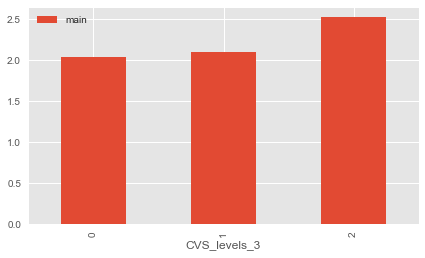

In [40]:
levels = pd.pivot_table(filtered_maxpre_data, values=['main'], index=['CVS_levels_3'],aggfunc=np.mean)
levels.plot(kind='bar')
print "This plot needs to be redone with standard deviation bars and colored by level and stars given the tests above"
print '0-1 => -'
print '1-2 => *'
print '0-2 => ***'

### Post-hoc analysis on experience in physic undergraduate labs

In [41]:
# posthoc_exp_physics_labs = pd.pivot_table(data, values=['main'], index=['experience_undergrad_labs'],aggfunc=(np.mean))
# posthoc_exp_physics_labs.plot(kind='bar')
# print "This plot needs to be redone with standard deviation bars and organized by sim, colored by level"

### Post-hoc analysis on order

In [42]:
# posthoc_sim_index = pd.pivot_table(data, values=['main'], index=['sim_index'],aggfunc=(np.mean))
# posthoc_sim_index.plot(kind='bar')
# print "This plot needs to be redone with standard deviation bars and organized by sim, colored by level"

### Post-hoc analysis on variable

In [43]:
# posthoc_variable = pd.pivot_table(data, values=['main'], index=['variable'],aggfunc=(np.mean))
# posthoc_variable.plot(kind='bar')
# print "This plot needs to be redone with standard deviation bars and organized by sim, colored by level"

Findings:
* CVS_levels=2 (graph) matters for all except Separation
* Pre matters for all except Width

## Repeat model for only student who use graph (85%)

In [44]:
formula = 'main ~ C(CVS_levels_3)' + covariates_for_parsimonious_model
model = ols(formula, filtered_maxpre_data[(filtered_maxpre_data[CVS]!=0)&(filtered_maxpre_data['use_graph']==1)]).fit()
print "\n\nModel: ",formula
print "Comparing CVS levels 1 and 2"
aov_table = anova_lm(model, typ=3)
eta_squared(aov_table)
omega_squared(aov_table)
print "\nAnova table using type 3 errors\n"
print(aov_table)



Model:  main ~ C(CVS_levels_3)+ variable + pre + sim_index + C(sid) + level_experience_sims + experience_undergrad_labs + used_similar_sim
Comparing CVS levels 1 and 2

Anova table using type 3 errors

                           sum_sq     df       F     PR(>F)     eta_sq  omega_sq
Intercept                  11.013    1.0  30.875  1.665e-07  8.456e-02     0.082
C(CVS_levels_3)             2.291    1.0   6.424  1.254e-02  1.759e-02     0.015
variable                    1.800    3.0   1.682  1.744e-01  1.382e-02     0.006
C(sid)                     68.895   85.0   2.272  1.707e-05  5.290e-01     0.295
pre                         0.083    1.0   0.232  6.310e-01  6.350e-04    -0.002
sim_index                   1.025    1.0   2.872  9.269e-02  7.867e-03     0.005
level_experience_sims       0.584    1.0   1.637  2.032e-01  4.483e-03     0.002
experience_undergrad_labs   0.793    1.0   2.222  1.387e-01  6.086e-03     0.003
used_similar_sim            0.591    1.0   1.658  2.003e-01  4.541e

# What affects use CVS-like inquiry strategies?

For some reason adding students in the matric turns it into a singular matrix and fails the analysis. Probably because two students are exactly identical?

## Overall, how much do they use it?

In [45]:
data['CVS_table'] = data['CVS_table_3']
data['CVS_graph'] = data['CVS_graph_3']
sums = pd.pivot_table(data, values=['CVS_table','CVS_graph'], index=['sid'], aggfunc=np.sum)

In [46]:
print data.shape

(592, 29)


In [47]:
for threshold in ['2','3','4','5']:
    print '\nFor CVs with {0} pts as a threshold'.format(threshold)
    sums = pd.pivot_table(data, values=['CVS_table_'+threshold,'CVS_graph_'+threshold], index=['sid'], aggfunc=np.sum)
    once = len(sums[sums['CVS_table_'+threshold]>0])/float(N)*100
    all4 = len(sums[sums['CVS_table_'+threshold]==4])/float(N)*100
    print "   {0}% of students use CVS table once and {1}% do it for all variables.".format(int(once),int(all4))
    once = len(sums[sums['CVS_graph_'+threshold]>0])/float(N)*100
    all4 = len(sums[sums['CVS_graph_'+threshold]==4])/float(N)*100
    print "   {0}% of students use CVS graph once and {1}% do it for all variables.".format(int(once),int(all4))


For CVs with 2 pts as a threshold
   93% of students use CVS table once and 47% do it for all variables.
   70% of students use CVS graph once and 29% do it for all variables.

For CVs with 3 pts as a threshold
   81% of students use CVS table once and 35% do it for all variables.
   65% of students use CVS graph once and 26% do it for all variables.

For CVs with 4 pts as a threshold
   68% of students use CVS table once and 30% do it for all variables.
   61% of students use CVS graph once and 23% do it for all variables.

For CVs with 5 pts as a threshold
   61% of students use CVS table once and 18% do it for all variables.
   55% of students use CVS graph once and 13% do it for all variables.


## Are they consistent in their usage of CVS graph?

In [48]:
sums2 = pd.pivot_table(data, values=['CVS_graph'], index=['sid','sim'], aggfunc=np.sum)
sums2 = sums2.reset_index(level=['sim','sid'])
# sums2.head()

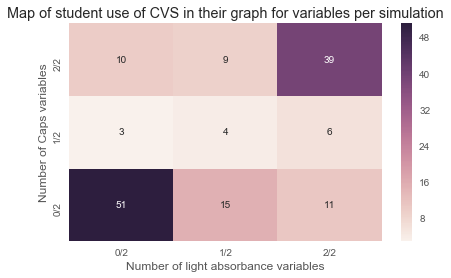

In [49]:
cvs_sim = np.zeros((3,3),dtype=int)
for i in range(3):
    for j in range(3):
        cvs_sim[i,j] = len(set(sums2[(sums2['sim']=='C')&(sums2['CVS_graph']==i)]['sid'])&set(sums2[(sums2['sim']=='L')&(sums2['CVS_graph']==j)]['sid']))
ax = sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d")
ax.set_xticklabels(['0/2','1/2','2/2'])
ax.set_yticklabels(['0/2','1/2','2/2'])
plt.xlabel('Number of light absorbance variables')
plt.ylabel('Number of Caps variables')
plt.title('Map of student use of CVS in their graph for variables per simulation')

High usage is consistent. If they do CVS with 1 variable in one sim, they do it with 2 in the other (probaly second sim).We'll see how order makes a difference later.

## What affects use of CVS
### Model with interaction (killed)

In [50]:
# formula = 'CVS_graph ~ pre*variable + sim_index*variable + pre*sim_index + level_experience_sims + experience_undergrad_labs + used_similar_sim'
# print 'model: ', formula,'\n'
# from patsy import dmatrices
# Y, X = dmatrices(formula, data, return_type = 'dataframe')
# # print X.columns
# logit = Logit(Y, X)
# model = logit.fit()
# print model.summary()
# # note that stats model has no module for running an anova on a logistic regression model

### Parismonious model

In [51]:
formula = 'CVS_graph ~ pre + variable + sim_index +level_experience_sims + experience_undergrad_labs + used_similar_sim'
print 'model: ', formula,'\n'
from patsy import dmatrices
Y, X = dmatrices(formula, data, return_type = 'dataframe')
# print X.columns
logit = Logit(Y, X)
model = logit.fit()
print model.summary()
# aov_table = anova_lm(model)
# eta_squared(aov_table)
# omega_squared(aov_table)
# # print "\nAnova table using type 2 errors\n"
# print(aov_table)

model:  CVS_graph ~ pre + variable + sim_index +level_experience_sims + experience_undergrad_labs + used_similar_sim 

Optimization terminated successfully.
         Current function value: 0.634028
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              CVS_graph   No. Observations:                  592
Model:                          Logit   Df Residuals:                      583
Method:                           MLE   Df Model:                            8
Date:                Fri, 02 Feb 2018   Pseudo R-squ.:                 0.07976
Time:                        17:04:25   Log-Likelihood:                -375.34
converged:                       True   LL-Null:                       -407.88
                                        LLR p-value:                 4.685e-11
                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

In order of what affects CVS_graph most:
* experience in undergraduate labs
* order
* prior knowledge

Having used a similar sim doesn't matter, variable doesn't matter and sim doesn't matter.

Experience in sims mattered before we included both physics and chem experience in labs

### post hoc of experience in undergraduate labs

In [52]:
# cvs_exp = pd.pivot_table(data, values=['CVS_graph'], index=['experience_undergrad_labs'],aggfunc=(np.mean,np.std))
# print "Here is prob that they do CVS graph depending on the experience_undergrad_labs"
# cvs_exp['CVS_graph']['mean'].plot.bar(yerr=cvs_exp['CVS_graph']['std'])

### post hoc of activity order

In [53]:
# cvs_exp = pd.pivot_table(data, values=['CVS_graph'], index=['sim_index'],aggfunc=(np.mean,np.std))
# print "Here is prob that they do CVS graph depending on sim_index"
# cvs_exp['CVS_graph']['mean'].plot.bar(yerr=cvs_exp['CVS_graph']['std'])

### post hoc of experience with sims

In [54]:
# cvs_exp = pd.pivot_table(data, values=['CVS_graph'], index=['level_experience_sims'],aggfunc=(np.mean,np.std))
# print "Here is prob that they do CVS graph depending on level_experience_sims"
# cvs_exp['CVS_graph']['mean'].plot.bar(yerr=cvs_exp['CVS_graph']['std'])
# print '''where:
#  0 -> None
#  1 -> 1-2 (roughly)
#  2 -> 3-5 (roughly)
#  3 -> 6+ (roughly)'''

### post hoc of pre

In [55]:
# cvs_pre = pd.pivot_table(data, values=['CVS_graph'], index=['pre'],aggfunc=(np.mean,np.std))
# print "Here is the avg pre score of students depending if they do CVS graph or not"
# cvs_pre['CVS_graph']['mean'].plot.bar(yerr=cvs_pre['CVS_graph']['std'])